157/157 [==============================] - 0s 1ms/step


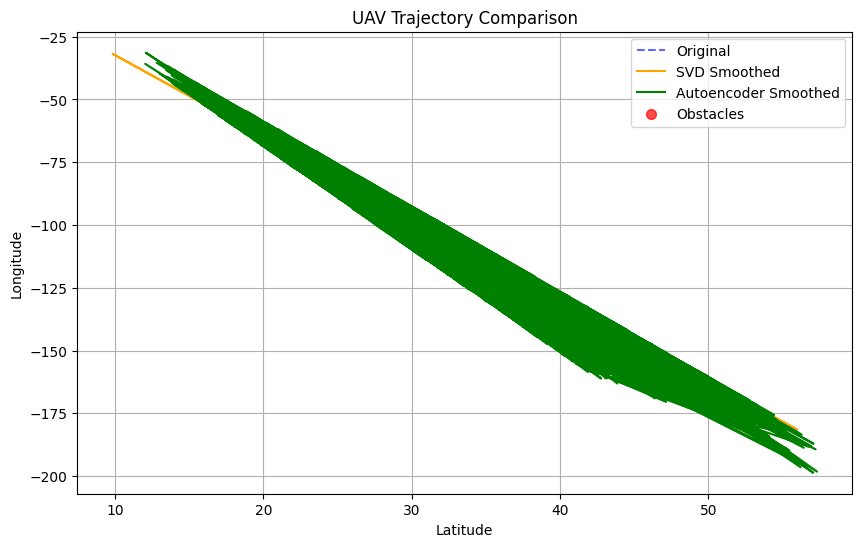

🧠 Performance Comparison:
🔸 Mean Squared Error (SVD): 1316.98785
🔸 Mean Squared Error (AE) : 2003.53705
🔸 Trajectory Smoothness (Std Dev of Gradient):
   Original: 0.00246, SVD: 17.53172, AE: 14.20688
🔸 Obstacle Detection Consistency:
   SVD: 90.00%, AE: 90.00%


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.spatial import KDTree
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load dataset
df = pd.read_csv('uav_navigation_dataset.csv')

# Sensor columns
sensor_columns = ['latitude', 'longitude', 'altitude', 
                  'imu_acc_x', 'imu_acc_y', 'imu_acc_z', 
                  'imu_gyro_x', 'imu_gyro_y', 'imu_gyro_z',
                  'lidar_distance', 'speed']
A = df[sensor_columns].values

# -------- SVD Fusion --------
svd = TruncatedSVD(n_components=3)
A_reduced = svd.fit_transform(A)
A_reconstructed = svd.inverse_transform(A_reduced)
df_svd = pd.DataFrame(A_reconstructed, columns=sensor_columns)

# -------- Autoencoder Fusion --------
X_train, X_test = train_test_split(A, test_size=0.2, random_state=42)

autoencoder = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(A.shape[1],)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(A.shape[1])
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=0)

A_ae_reconstructed = autoencoder.predict(A)
df_ae = pd.DataFrame(A_ae_reconstructed, columns=sensor_columns)

# -------- Obstacle Detection --------
threshold = df['lidar_distance'].quantile(0.1)
df['obstacle_detected'] = df['lidar_distance'] < threshold
df_svd['obstacle_detected'] = df_svd['lidar_distance'] < threshold
df_ae['obstacle_detected'] = df_ae['lidar_distance'] < threshold

# -------- Performance Metrics --------
# 1. MSE
mse_svd = mean_squared_error(A, A_reconstructed)
mse_ae = mean_squared_error(A, A_ae_reconstructed)

# 2. Trajectory Smoothness (using gradient variation)
def gradient_variation(lat, lon):
    grad_lat = np.gradient(lat)
    grad_lon = np.gradient(lon)
    smoothness = np.std(np.sqrt(grad_lat**2 + grad_lon**2))
    return smoothness

smooth_original = gradient_variation(df['latitude'], df['longitude'])
smooth_svd = gradient_variation(df_svd['latitude'], df_svd['longitude'])
smooth_ae = gradient_variation(df_ae['latitude'], df_ae['longitude'])

# 3. Obstacle detection consistency
def obstacle_consistency(ref, test):
    return np.mean(ref == test)

consistency_svd = obstacle_consistency(df['obstacle_detected'], df_svd['obstacle_detected'])
consistency_ae = obstacle_consistency(df['obstacle_detected'], df_ae['obstacle_detected'])

# -------- Visualization --------
plt.figure(figsize=(10, 6))
plt.plot(df['latitude'], df['longitude'], 'b--', label='Original', alpha=0.6)
plt.plot(df_svd['latitude'], df_svd['longitude'], color='orange', label='SVD Smoothed')
plt.plot(df_ae['latitude'], df_ae['longitude'], color='green', label='Autoencoder Smoothed')
plt.scatter(df[df['obstacle_detected']]['latitude'], df[df['obstacle_detected']]['longitude'],
            color='red', s=50, label='Obstacles', alpha=0.7)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("UAV Trajectory Comparison")
plt.legend()
plt.grid()
plt.show()

# -------- Save Results --------
df_svd.to_csv('svd_denoised_uav_trajectory2.csv', index=False)
df_ae.to_csv('autoencoder_denoised_uav_trajectory.csv', index=False)

# -------- Display Metrics --------
print("🧠 Performance Comparison:")
print(f"🔸 Mean Squared Error (SVD): {mse_svd:.5f}")
print(f"🔸 Mean Squared Error (AE) : {mse_ae:.5f}")
print(f"🔸 Trajectory Smoothness (Std Dev of Gradient):")
print(f"   Original: {smooth_original:.5f}, SVD: {smooth_svd:.5f}, AE: {smooth_ae:.5f}")
print(f"🔸 Obstacle Detection Consistency:")
print(f"   SVD: {consistency_svd*100:.2f}%, AE: {consistency_ae*100:.2f}%")
